# **Graph Analytics**
**Using Spark GraphX**



---


# **Spark and GraphFrames Set Up**


In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 37.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=24b4dbbce8a11a823426c0c768b341e641c074377f1de9a44bb84b94d11a35c5
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
     |████████████████████████████████| 154 kB 12.3 MB/s 


Download the graphframes jar file from: [Graphframe jar file:](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)

Upload it in the Google Colab Files folder. Can be found in the left pane of this window.

In [ ]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [ ]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# **CPDB Analysis(1)**

Analyze the police officers connection with allegations

In [ ]:
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [ ]:
cursor = conn.cursor()

**Following query creates nodes and edges to answer the questions.**



*   **nodes**: id, officer name and sustained count
*   **edges**: src(officer1 id), dist(officer2 id) and relationship(sustained count)

In [ ]:
edges_query = '''SELECT da1.officer_id src, da2.officer_id dst, count(da1.allegation_category_id) relationship
FROM data_officerallegation da1 JOIN data_officerallegation da2
    ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id
join data_officer d1 on da1.officer_id = d1.id
join data_officer d2 on da2.officer_id = d2.id
join data_allegationcategory d3 on da1.allegation_category_id = d3.id
join data_allegationcategory d4 on da2.allegation_category_id = d4.id
where da1.final_finding = 'SU' and d1.rank = 'Police Officer' and da2.final_finding = 'SU' and d2.rank = 'Police Officer'
  and d3.category = 'Operation/Personnel Violations' and d4.category = 'Operation/Personnel Violations'
group by da1.officer_id, da2.officer_id
order by relationship desc;'''

In [ ]:
nodes_query = '''select da.id,da.first_name || ' ' || da.last_name officer_name,COUNT(d.category) as sustained_count
from data_officer da
join data_officerallegation doa on da.id = doa.officer_id
join data_allegationcategory d on doa.allegation_category_id = d.id
where da.rank = 'Police Officer' and doa.final_finding = 'SU' and d.category = 'Operation/Personnel Violations'
group by da.id, d.category
    order by da.id;'''

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 17465

df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

print(df_edges.shape)

shape is: 5273
(5273, 3)


In [ ]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 17465

df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

print(df_nodes.shape)

shape is: 4612
(4612, 3)


In [ ]:
edges_ = spark.createDataFrame(df_edges)

In [ ]:
nodes = spark.createDataFrame(df_nodes)

In [ ]:
cpdb = GraphFrame(nodes, edges_)

In [ ]:
cpdb.vertices.show()

+---+---------------+---------------+
| id|   officer_name|sustained_count|
+---+---------------+---------------+
|  6| Anthony Abbate|              2|
| 17|Moulay Abdullah|              1|
| 18|  Jason Abejero|              1|
| 21|Deborah Abelson|              3|
| 29|   Henry Abrams|              1|
| 47| Rafael Acevedo|              1|
| 50| Nadine Acevedo|              2|
| 54|   Jeff Acevedo|              1|
| 58| Manuel Acevedo|              5|
| 59| Edward Acevedo|              2|
| 75|   Mario Acosta|              1|
| 79|     Erwin Acox|              1|
| 80| Zaireh Acsvecs|              1|
| 89|Randy Adamovitz|              1|
| 90|    Craig Adams|              3|
| 97|   Wilbur Adams|              1|
|100|   Marvin Adams|              2|
|105|Christoph Adams|              2|
|108|    Vicky Adams|              2|
|110|    Lloyd Adams|              3|
+---+---------------+---------------+
only showing top 20 rows



In [ ]:
cpdb.edges.show()

+-----+-----+------------+
|  src|  dst|relationship|
+-----+-----+------------+
|27740|30737|           3|
|  309| 6075|           2|
| 9491|31328|           2|
|28278|28999|           2|
|19501|31818|           2|
| 2400|15354|           2|
| 8156|18223|           2|
|22906|30108|           2|
|13594|13788|           2|
| 6084|19477|           2|
| 7829|28560|           2|
|15195|24973|           2|
| 9517|27740|           2|
|30737|32294|           2|
| 9517|30737|           2|
|11731|18042|           2|
| 9517|32294|           2|
|12160|15760|           2|
|30849|31248|           2|
| 5829|20792|           2|
+-----+-----+------------+
only showing top 20 rows



**Implement Graph Algorithms**

In [ ]:
tc_cpdb = cpdb.triangleCount()
tc_cpdb.select("id","officer_name","count").dropDuplicates().orderBy('count',ascending = False).show()


+-----+----------------+-----+
|   id|    officer_name|count|
+-----+----------------+-----+
|12788|William Humphrey| 3723|
| 6387|     Percy Davis| 3636|
| 5667|   Jerry Crawley| 3573|
| 6260|     James David| 3570|
|10986| Vincent Guiffra| 3570|
|  258|   Robert Alanis| 3570|
|13401|  Johnny Jenkins| 3570|
| 4699|  Joseph Cistaro| 3570|
|13794|  Benjamin Jones| 3570|
| 8134|       Roy Evans| 3570|
|11537|    Andre Harris| 3570|
|10227|    James Golich| 3570|
| 9555|   Wilman Garcia| 3570|
| 9713|      Gary Gaski| 3570|
|  944|   Raymond Augle| 3570|
| 5756|   Lenwood Cross| 3570|
|  923|   Jesse Atilano| 3570|
|  911|   Tyrone Askins| 3570|
|13732|   Lorenzo Jones| 3570|
|10556|   Jack Granadon| 3570|
+-----+----------------+-----+
only showing top 20 rows



In [ ]:
pr_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)
#look at the pagerank score for every vertex
pr_cpdb.vertices.dropDuplicates().orderBy('pagerank', ascending=False).show()

+-----+----------------+---------------+------------------+
|   id|    officer_name|sustained_count|          pagerank|
+-----+----------------+---------------+------------------+
|32192|   Dereck Miller|              2| 40.97297768180862|
|31756|     Jose Zuniga|             15|23.550374153558035|
|30342| Christoph Wells|              1|14.710267738714268|
|30663| Ronald Williams|              2|11.814155914780049|
|29807|  Richard Walker|              1|11.462546289907223|
|30294|    Daniel Weems|              1|10.586822550956482|
|31648|   Andres Zepeda|              1|10.057465668696398|
|29046|   Isaiah Turner|              2| 9.457956097235726|
|28556|   Robert Thorpe|              3| 8.084936168448614|
|27708|Antionett Strong|              1| 7.081695913969587|
|30223|Gerald Waxmonsky|              3| 7.032093966103569|
|26851|    Ronald Smith|              3| 6.932595904355005|
|27349| Charles Stanton|              2| 6.318782167932732|
|30653|      Alan Wilks|              1|

In [ ]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM
# from graphframes.examples import Graphs
# g = Graphs(sqlContext).friends()  # Get example graph

msgToSrc = AM.dst["sustained_count"]
msgToDst = AM.src["sustained_count"]
agg = cpdb.aggregateMessages(
    sqlsum(AM.msg).alias("summedAllegations"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['summedAllegations'],ascending=False).show()

+-----+-----------------+
|   id|summedAllegations|
+-----+-----------------+
|12788|              311|
| 6387|              295|
|26851|              274|
| 9555|              271|
|18042|              270|
| 5667|              269|
|13108|              269|
|21442|              269|
|  258|              268|
| 4699|              268|
|  124|              268|
| 8057|              268|
|13366|              268|
|   29|              268|
|30342|              268|
|16747|              268|
|10986|              268|
|26774|              268|
|10227|              268|
|  944|              268|
+-----+-----------------+
only showing top 20 rows



In [ ]:
# NetworkX to visualize the graph
import networkx as nx

def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw_circular(g, arrows = True)

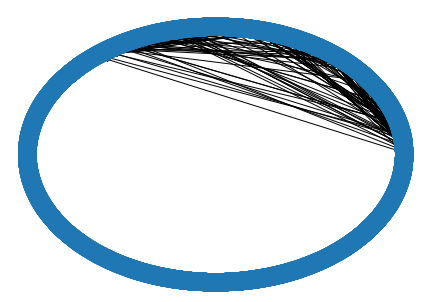

In [ ]:
plot_graph(cpdb)

In [ ]:
cpdb.degrees.sort(['Degree'],ascending=[0]).show()

+-----+------+
|   id|degree|
+-----+------+
|12788|   103|
| 6387|    97|
| 9555|    89|
| 5667|    88|
|31756|    88|
|18042|    87|
|23534|    87|
|26851|    87|
|10389|    86|
| 2604|    86|
|13108|    86|
| 6534|    86|
|24185|    86|
|21442|    86|
|13732|    86|
|10556|    86|
|13366|    85|
|13794|    85|
|13401|    85|
| 8057|    85|
+-----+------+
only showing top 20 rows



In [ ]:
communities = cpdb.labelPropagation(maxIter=40)
communities.persist().show(10)
print (f"There are {communities.select('label').distinct().count()} communities in this sample graph.")

+-----+------------------+---------------+-----+
|   id|      officer_name|sustained_count|label|
+-----+------------------+---------------+-----+
|   29|      Henry Abrams|              1|29807|
| 2214|      Calvin Blunt|              3|23072|
| 5556|   Ramon Covington|              1| 5556|
|11190|    Mahmoud Haleem|              1|11190|
|13401|    Johnny Jenkins|              8|29807|
|19979|    Dennis Murdock|              1|22809|
|28242|      Andre Taylor|              1|28242|
|29824|      Myrta Walker|              1|29824|
|31156|      Emmit Womack|              1|31156|
|31703|Bernice Ziolkowski|              2|31703|
+-----+------------------+---------------+-----+
only showing top 10 rows

There are 4041 communities in this sample graph.


In [ ]:
communities.groupby('label').count().sort('count', ascending=False).show()

+-----+-----+
|label|count|
+-----+-----+
|29807|  113|
|22809|   25|
| 5439|   19|
|30294|   17|
|11573|   11|
|29403|    9|
|21986|    9|
| 5520|    8|
|20820|    8|
|24247|    8|
| 8481|    8|
|12745|    7|
|30518|    6|
|15936|    6|
|21436|    6|
| 9001|    6|
|23631|    6|
|28153|    6|
|21777|    6|
|31619|    5|
+-----+-----+
only showing top 20 rows



# **CPDB Analysis(2)**

Analyze the police officers connection with allegations

**Following query creates nodes and edges to answer the questions.**



*   **nodes**: id, officer name and sustained count
*   **edges**: src(officer1 id), dist(officer2 id) and relationship(sustained count)

In [ ]:
edges_query = '''SELECT da1.officer_id src, da2.officer_id dst, count(da1.allegation_category_id) relationship
FROM data_officerallegation da1 JOIN data_officerallegation da2
    ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id
join data_officer d1 on da1.officer_id = d1.id
join data_officer d2 on da2.officer_id = d2.id
join data_allegationcategory d3 on da1.allegation_category_id = d3.id
join data_allegationcategory d4 on da2.allegation_category_id = d4.id
where da1.final_finding = 'SU' and d1.rank = 'Police Officer' and da2.final_finding = 'SU' and d2.rank = 'Police Officer'
  and d3.category = 'Conduct Unbecoming (Off-Duty)' and d4.category = 'Conduct Unbecoming (Off-Duty)'
group by da1.officer_id, da2.officer_id
order by relationship desc;'''

In [ ]:
nodes_query = '''select da.id,da.first_name || ' ' || da.last_name officer_name,COUNT(d.category) as sustained_count
from data_officer da
join data_officerallegation doa on da.id = doa.officer_id
join data_allegationcategory d on doa.allegation_category_id = d.id
where da.rank = 'Police Officer' and doa.final_finding = 'SU' and d.category = 'Conduct Unbecoming (Off-Duty)'
group by da.id, d.category
    order by da.id;'''

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 17465

df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

print(df_edges.shape)

shape is: 1218
(1218, 3)


In [ ]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 17465

df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

print(df_nodes.shape)

shape is: 1319
(1319, 3)


In [ ]:
edges_ = spark.createDataFrame(df_edges)

In [ ]:
nodes = spark.createDataFrame(df_nodes)

In [ ]:
cpdb = GraphFrame(nodes, edges_)

In [ ]:
cpdb.vertices.show()

+---+-----------------+---------------+
| id|     officer_name|sustained_count|
+---+-----------------+---------------+
| 21|  Deborah Abelson|              1|
| 29|     Henry Abrams|              1|
| 45|    Pedro Acevedo|              1|
| 58|   Manuel Acevedo|              2|
| 89|  Randy Adamovitz|              1|
|117|      James Adams|              1|
|160|    Mahir Affaneh|              1|
|191|  Edward Aguilera|              2|
|199|Kathleen Aguinaga|              2|
|220|    Terry Ahlgrim|              1|
|225|    Maurice Ahmed|              1|
|241|   Willie Akerson|              1|
|245|     Jimmie Akins|              1|
|258|    Robert Alanis|              1|
|344|     Joel Algarin|              1|
|376|     Gloria Allen|              1|
|387|    Raymond Allen|              1|
|396|    Michael Allen|              1|
|420|  Xavier Almaguer|              1|
|422|   Joseph Almanza|              1|
+---+-----------------+---------------+
only showing top 20 rows



In [ ]:
cpdb.edges.show()

+-----+-----+------------+
|  src|  dst|relationship|
+-----+-----+------------+
|  985|17287|           2|
|25262|28807|           2|
|  191|22319|           1|
|  191|29285|           1|
|  860| 1938|           1|
|  923|15982|           1|
|  947|15308|           1|
|  974|  985|           1|
|  974| 2085|           1|
|  974| 2323|           1|
|  974| 2978|           1|
|  974| 3027|           1|
|  974| 4249|           1|
|  974| 4408|           1|
|  974| 6155|           1|
|  974| 6250|           1|
|  974| 6857|           1|
|  974| 8602|           1|
|  974| 8658|           1|
|  974| 8992|           1|
+-----+-----+------------+
only showing top 20 rows



**Implement Graph Algorithms**

In [ ]:
tc_cpdb = cpdb.triangleCount()
tc_cpdb.select("id","officer_name","count").dropDuplicates().orderBy('count',ascending = False).show()


+-----+-----------------+-----+
|   id|     officer_name|count|
+-----+-----------------+-----+
|  985|     Joseph Avila| 1080|
|17287|  Charles Maratre| 1080|
|  974|    Bernard Avant| 1038|
|10902|   David Grubisic| 1035|
|31906|      James Davis| 1035|
| 2323|      Craig Bolin| 1035|
|10352|Enriquez Gonzalez| 1035|
| 3027|      David Brown| 1035|
| 8602|    Lolita Fisher| 1035|
|13207|      Rufus James| 1035|
| 4408| Nicolas Chapello| 1035|
|13401|   Johnny Jenkins| 1035|
|19052|        Che Miles| 1035|
|15668|  Darryl Langston| 1035|
| 8992|     Henry Foster| 1035|
|11413|     Wadell Hardy| 1035|
| 8658|      Corey Flagg| 1035|
| 2085|      Eural Black| 1035|
|22172|       Aaron Pena| 1035|
| 6155|     Fred Dammons| 1035|
+-----+-----------------+-----+
only showing top 20 rows



In [ ]:
pr_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)
#look at the pagerank score for every vertex
pr_cpdb.vertices.dropDuplicates().orderBy('pagerank', ascending=False).show()

+-----+--------------------+---------------+------------------+
|   id|        officer_name|sustained_count|          pagerank|
+-----+--------------------+---------------+------------------+
|32323|        Jerry Scaife|              1|24.030912366209257|
|31906|         James Davis|              1|13.009611474979001|
|30921|       Leigha Wilson|              1| 9.129551912265967|
|29817|      Herbert Walker|              2| 7.122709294673093|
|26497|    Lonnie Singleton|              1| 5.876637866365711|
|31275|       Ernest Wright|              1|5.7050918902945815|
|26167|       Teresa Shegog|              3| 5.022767407150179|
|23936|      Steven Ridgner|              2| 4.405013497829839|
|23859|Janice Richard Ka...|              2|3.9307799866696236|
|23265|     Robert Quintero|              2|  3.55450967199834|
|22172|          Aaron Pena|              3| 3.248224962353675|
|27911|      Rennard Sutton|              1|3.0996310600865105|
|21890|         Sammie Parr|            

**Message Passing using aggregateMessages()**

In [ ]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM
# from graphframes.examples import Graphs
# g = Graphs(sqlContext).friends()  # Get example graph

# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["sustained_count"]
msgToDst = AM.src["sustained_count"]
agg = cpdb.aggregateMessages(
    sqlsum(AM.msg).alias("summedAllegations"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['summedAllegations'],ascending=False).show()

+-----+-----------------+
|   id|summedAllegations|
+-----+-----------------+
|17287|               81|
|  985|               81|
|  974|               73|
| 8658|               70|
|20286|               70|
|16886|               70|
| 6250|               70|
|19934|               70|
|11413|               70|
| 4249|               70|
| 4408|               70|
| 2085|               70|
|16345|               70|
|10902|               70|
| 2323|               70|
|18059|               70|
|10352|               70|
| 3027|               70|
|19052|               70|
|26497|               70|
+-----+-----------------+
only showing top 20 rows



In [ ]:
# NetworkX to visualize the graph
import networkx as nx

def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw_kamada_kawai(g, arrows = True)

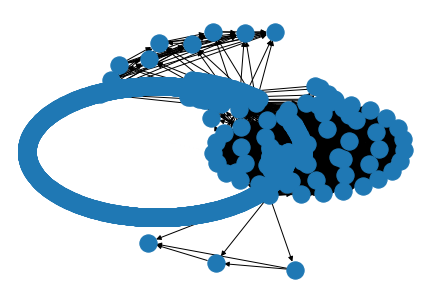

In [ ]:
plot_graph(cpdb)

In [ ]:
cpdb.degrees.sort(['Degree'],ascending=[0]).show()

+-----+------+
|   id|degree|
+-----+------+
|17287|    55|
|  985|    55|
|  974|    49|
|26167|    46|
| 9617|    46|
|15668|    46|
|22172|    46|
|19052|    46|
|19856|    46|
|11184|    46|
|31906|    46|
|29817|    46|
| 6250|    46|
|16167|    46|
|20078|    46|
|19684|    46|
|18059|    46|
|16875|    46|
|14313|    46|
| 8992|    46|
+-----+------+
only showing top 20 rows



In [ ]:
communities = cpdb.labelPropagation(maxIter=40)
communities.persist().show(10)
print (f"There are {communities.select('label').distinct().count()} communities in this sample graph.")

+-----+--------------------+---------------+-----+
|   id|        officer_name|sustained_count|label|
+-----+--------------------+---------------+-----+
|   29|        Henry Abrams|              1|   29|
| 2214|        Calvin Blunt|              1| 2214|
| 2453|       Joseph Boston|              2| 2453|
| 3764|       Sean Campbell|              1| 3764|
|13401|      Johnny Jenkins|              4|22172|
|  191|     Edward Aguilera|              2|  191|
| 1360|Donna Barnes Simmons|              1| 1360|
| 3280|       Andre Bullock|              2| 3280|
|12967|         Sonia Irwin|              1|12967|
|22102|       John Pechulis|              1|22102|
+-----+--------------------+---------------+-----+
only showing top 10 rows

There are 1246 communities in this sample graph.


In [ ]:
#only shows the top 5 rows
communities.groupby('label').count().sort('count', ascending=False).show()

+-----+-----+
|label|count|
+-----+-----+
|22172|   47|
|21197|    9|
|  191|    4|
| 2400|    3|
|24473|    3|
|26533|    3|
| 6393|    3|
|11229|    3|
| 9688|    3|
| 2978|    3|
|22365|    3|
|   29|    1|
| 1360|    1|
| 2214|    1|
| 3280|    1|
|25946|    1|
| 2453|    1|
|12967|    1|
| 8330|    1|
| 3764|    1|
+-----+-----+
only showing top 20 rows

